In [1]:
import os
from torchsig.image_datasets.datasets.synthetic_signals import GeneratorFunctionDataset, rectangle_signal_generator_function, tone_generator_function, repeated_signal_generator_function, chirp_generator_function
from torchsig.image_datasets.datasets.file_loading_datasets import SOIExtractorDataset, LazyImageDirectoryDataset
from torchsig.image_datasets.datasets.composites import ConcatDataset
from torchsig.image_datasets.datasets.yolo_datasets import YOLOImageCompositeDataset, YOLODatasetAdapter, YOLODatum
from torchsig.image_datasets.transforms.impairments import BlurTransform, RandomGaussianNoiseTransform, RandomImageResizeTransform, RandomRippleNoiseTransform, ScaleTransform, scale_dynamic_range, normalize_image
from torchsig.image_datasets.plotting.plotting import plot_yolo_boxes_on_image, plot_yolo_datum
from torchsig.image_datasets.datasets.protocols import CFGSignalProtocolDataset, FrequencyHoppingDataset, random_hopping, YOLOFrequencyHoppingDataset, YOLOCFGSignalProtocolDataset

from torchsig.datasets.modulations import ModulationsDataset
import torchsig.transforms as ST
import numpy as np

from torchsig.image_datasets.dataset_generation import batched_write_yolo_synthetic_dataset

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [3]:
def add_falling_edge(img_tnsr):
    img_tnsr[:,:,-1] = 1
    return img_tnsr

rising_chirp = GeneratorFunctionDataset(chirp_generator_function(1, 20, 4, random_height_scale = [0.9,1.1], random_width_scale = [1,2]), 
                                        transforms=add_falling_edge)
falling_chirp = GeneratorFunctionDataset(chirp_generator_function(1, 20, 4, random_height_scale = [0.9,1.1], random_width_scale = [1,2]), 
                                         transforms=[add_falling_edge, lambda x: x.flip(-1)])

chirp_stream_ds = CFGSignalProtocolDataset('cfg_signal')
chirp_stream_ds.add_rule('cfg_signal', ['rising_or_falling_stream'] + ['rising_falling_or_null']*12)
chirp_stream_ds.add_rule('rising_falling_or_null', 'rising_or_falling_stream', 1)
chirp_stream_ds.add_rule('rising_falling_or_null', 'null', 1)
chirp_stream_ds.add_rule('null', None)
chirp_stream_ds.add_rule('rising_or_falling_stream', 'rising_stream')
chirp_stream_ds.add_rule('rising_or_falling_stream', 'falling_stream')
chirp_stream_ds.add_rule('rising_stream', ['rising_segment'] + ['rising_segment_or_null']*2)
chirp_stream_ds.add_rule('rising_segment_or_null', 'rising_segment')
chirp_stream_ds.add_rule('rising_segment_or_null', 'null')
chirp_stream_ds.add_rule('rising_segment', ['rising_chirp']*3)
chirp_stream_ds.add_rule('rising_chirp', rising_chirp)
chirp_stream_ds.add_rule('falling_stream', ['falling_segment'] + ['falling_segment_or_null']*2)
chirp_stream_ds.add_rule('falling_segment_or_null', 'falling_segment')
chirp_stream_ds.add_rule('falling_segment_or_null', 'null')
chirp_stream_ds.add_rule('falling_segment', ['falling_chirp']*3)
chirp_stream_ds.add_rule('falling_chirp', falling_chirp)

yolo_chirp_stream_ds = YOLODatasetAdapter(chirp_stream_ds, class_id=0)

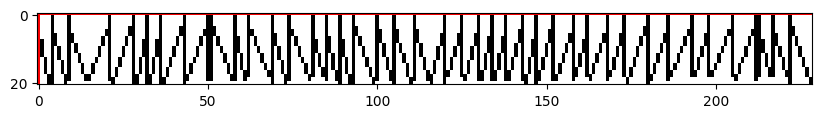

In [4]:
plot_yolo_datum(yolo_chirp_stream_ds[0])

In [5]:
big_chirp_fn = chirp_generator_function(2, 8, 2, random_height_scale = [0.8,1.2], random_width_scale = [0.5,2])
small_chirp_fn = chirp_generator_function(2, 4, 2, random_height_scale = [0.8,1.2], random_width_scale = [0.5,2])
init_chirp_fn = chirp_generator_function(4, 2, 3, random_height_scale = [0.8,1.2], random_width_scale = [0.8,1.2])
exit_chirp_fn = chirp_generator_function(2, 2, 2, random_height_scale = [0.8,1.2], random_width_scale = [0.8,1.2])

bytes_ds = CFGSignalProtocolDataset('cfg_signal')
bytes_ds.add_rule('cfg_signal', ['init_chirp', 'main_signal', 'exit_signal'])
bytes_ds.add_rule('main_signal_chirp', ['bit_chirp']*8)
bytes_ds.add_rule('bit_chirp', big_chirp_fn)
bytes_ds.add_rule('bit_chirp', small_chirp_fn)
bytes_ds.add_rule('main_signal', (['main_signal_chirp_or_null']*3)+['main_signal_chirp'])
bytes_ds.add_rule('main_signal_chirp_or_null', 'main_signal_chirp', 1)
bytes_ds.add_rule('main_signal_chirp_or_null', 'null', 1)
bytes_ds.add_rule('null', None)
bytes_ds.add_rule('init_chirp', init_chirp_fn)
bytes_ds.add_rule('exit_signal', [exit_chirp_fn, exit_chirp_fn, exit_chirp_fn])

yolo_bytes_ds = YOLODatasetAdapter(bytes_ds, class_id=0)

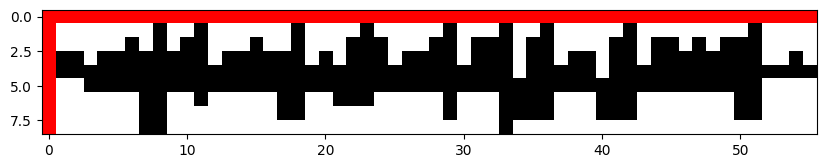

In [6]:
plot_yolo_datum(yolo_bytes_ds[0])

In [7]:
hopper_ds = YOLOFrequencyHoppingDataset(yolo_bytes_ds, [20,80], 10, [100,100], [4,8])
random_hopper_ds = YOLOFrequencyHoppingDataset(yolo_bytes_ds, [20,80], 10, [100,100], [4,8], hopping_function=random_hopping)

two_mode_hopper = YOLOCFGSignalProtocolDataset('two_mode_hopping')
two_mode_hopper.add_rule('two_mode_hopping',['12'])
two_mode_hopper.add_rule('two_mode_hopping',['21'])
two_mode_hopper.add_rule('two_mode_hopping',['1'])
two_mode_hopper.add_rule('two_mode_hopping',['2'])
two_mode_hopper.add_rule('12_or_null','12')
two_mode_hopper.add_rule('12_or_null','null', 2)
two_mode_hopper.add_rule('null',None)
two_mode_hopper.add_rule('21_or_null','null', 2)
two_mode_hopper.add_rule('21_or_null','21')
two_mode_hopper.add_rule('12',['1','2'])
two_mode_hopper.add_rule('21',['2','1'])
two_mode_hopper.add_rule('1',hopper_ds)
two_mode_hopper.add_rule('2',random_hopper_ds)

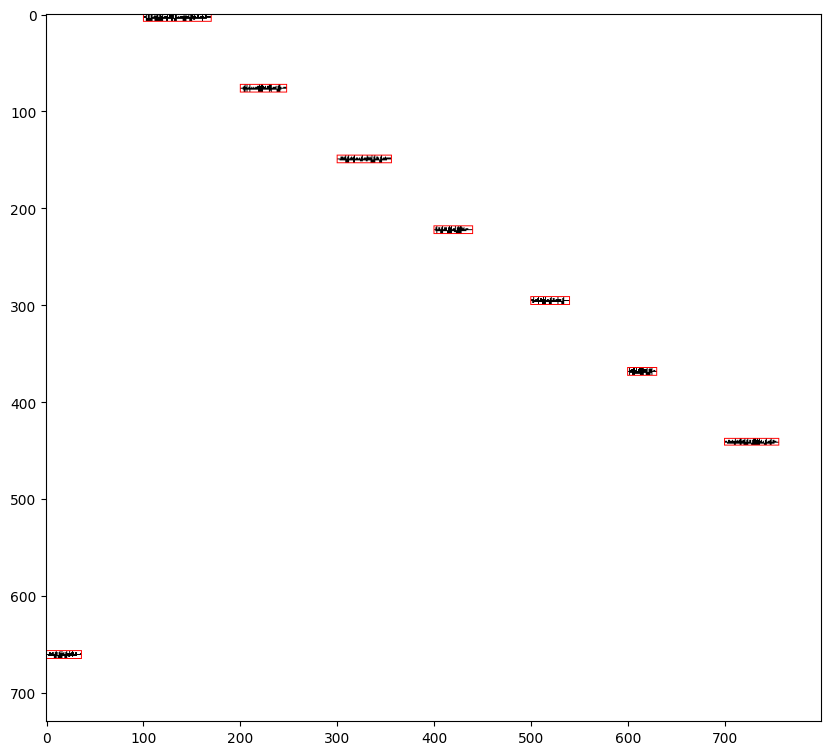

In [8]:
plot_yolo_datum(two_mode_hopper[0])

In [9]:
def threshold_mod_signal(signal):
    signal[signal**4<0.02] = 0
    return signal[:,:,5:-5] # cuts off the edns to look more seemless in composites

mod_ds_transform = ST.Compose([
    ST.Normalize(norm=np.inf, flatten=True),
    ST.Spectrogram(nperseg=128, noverlap=0, nfft=128, mode='psd',detrend=None,scaling='density'),
    ST.Normalize(norm=np.inf, flatten=True),
    ST.SpectrogramImage()
])

mod_ds = ModulationsDataset(
            level=0, 
            num_samples=53000,
            num_iq_samples=2*128**2,
            use_class_idx=True,
            include_snr=False,
            transform=mod_ds_transform
        )

signal_transforms = []
signal_transforms += [normalize_image]
signal_transforms += [RandomImageResizeTransform([0.02,1.5])]
signal_transforms += [BlurTransform(strength=0.5, blur_shape=(5,1))]
signal_transforms += [threshold_mod_signal]
signal_transforms += [BlurTransform(strength=1, blur_shape=(5,1))]

mod_spec_dataset = GeneratorFunctionDataset(lambda : 1 - mod_ds[np.random.randint(len(mod_ds))][0].mean(axis=-1)[None,:,:], transforms=signal_transforms)

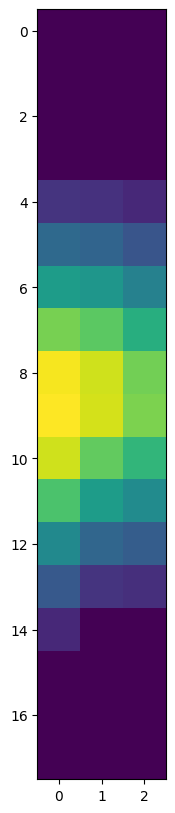

In [10]:
plt.imshow(mod_spec_dataset[0][0])

In [11]:
def clamp_max_by_std(signal):
    signal[signal > signal.mean() + signal.std()*3] = signal.mean() + signal.std()*3
    return signal

spectrogram_size = (1,1024,1024)

two_mode_hopper.transforms = [lambda x: YOLODatum(BlurTransform(strength=1, blur_shape=(5,1))(x.img), x.labels)]
composite_transforms = []
composite_transforms += [clamp_max_by_std] # limit dynamic range due to overlapping signals
composite_transforms += [normalize_image] # inf norm
composite_transforms += [RandomGaussianNoiseTransform(mean=0, range=(0.2,0.8))] # add background noise
composite_transforms += [scale_dynamic_range]
composite_transforms += [normalize_image] # inf norm
composite_spectrogram_dataset = YOLOImageCompositeDataset(spectrogram_size, transforms=composite_transforms, dataset_size=250000, max_add=True)
composite_spectrogram_dataset.add_component(yolo_chirp_stream_ds, min_to_add=0, max_to_add=3, use_source_yolo_labels=True)
composite_spectrogram_dataset.add_component(bytes_ds, min_to_add=0, max_to_add=3, class_id=0)
composite_spectrogram_dataset.add_component(two_mode_hopper, min_to_add=0, max_to_add=1, use_source_yolo_labels=True)
composite_spectrogram_dataset.add_component(mod_spec_dataset, min_to_add=1, max_to_add=6, class_id=0)

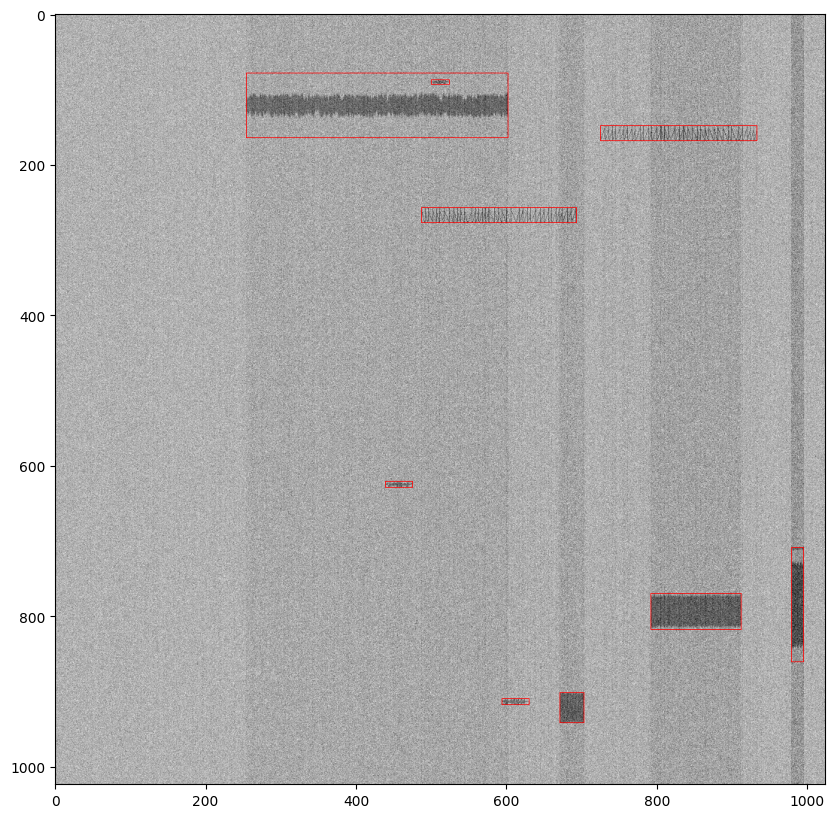

In [14]:
sample_datum = composite_spectrogram_dataset[0]
plot_yolo_datum(sample_datum)

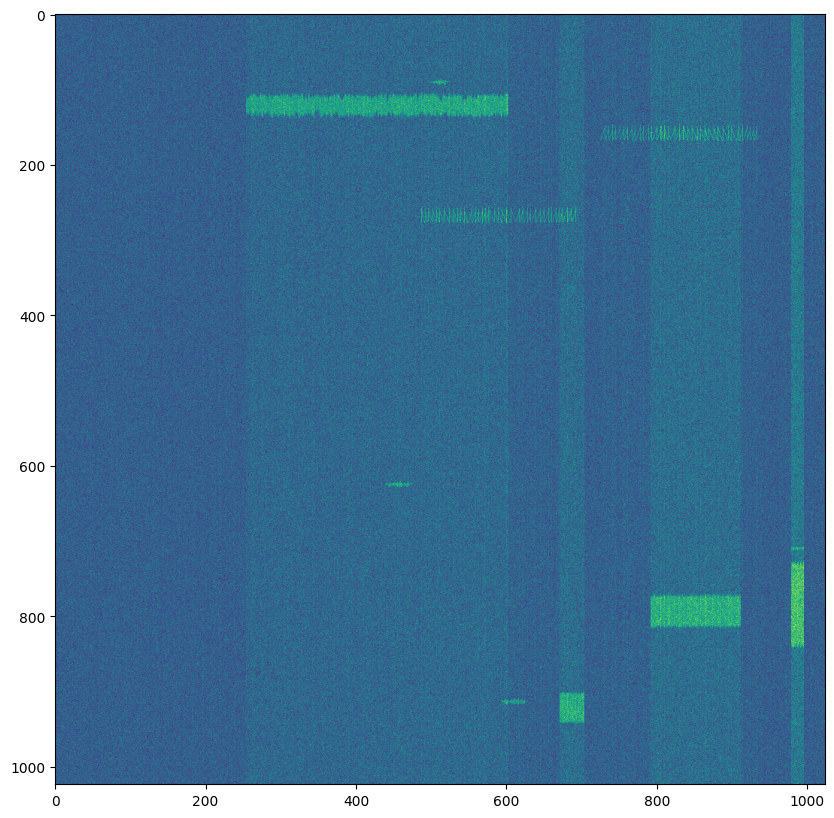

In [15]:
plt.imshow(sample_datum[0][0])